# Customer Churn Prediction Model


The goal is to Create a Model to Predict Whether or Not a Customer will Churn .

----
----

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning Libraries
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
from bayes_opt import BayesianOptimization
from imblearn.over_sampling import SMOTE

# Explainability Libraries
# import shap

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the dataset
df = pd.read_csv('Telco-Customer-Churn.csv')

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


---
---

## 1. Data Check & EDA

checked datatypes and non-null values in the dataframe

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


Based on the statistical summary of the numeric columns with .describe() , I noticed that many columns are categorical, meaning I will eventually need to convert them to dummy variables.

In [5]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [6]:
df.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Confirmed that there are no NaN cells by displaying NaN values per feature column.

<Axes: xlabel='Churn', ylabel='count'>

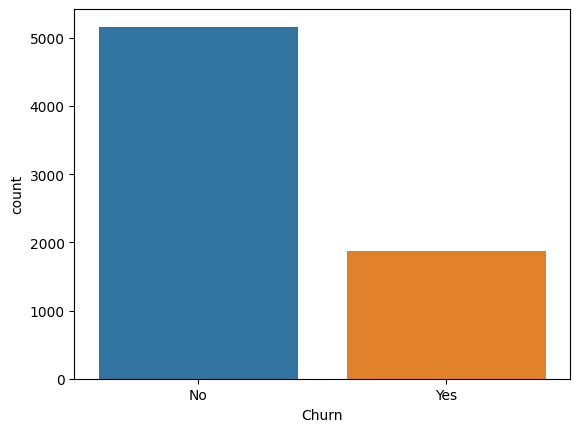

In [7]:
sns.countplot(data=df,x='Churn', hue = 'Churn')

Displayed the balance of the class labels (Churn) with a Count Plot.

<Axes: xlabel='Churn', ylabel='TotalCharges'>

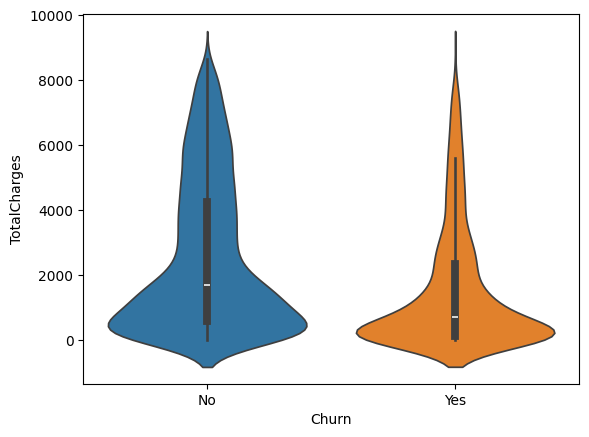

In [8]:
sns.violinplot(data=df,x='Churn',y='TotalCharges', hue="Churn")

Displayed the distrbution of TotalCharges between Churn categories with a Box Plot or Violin Plot.

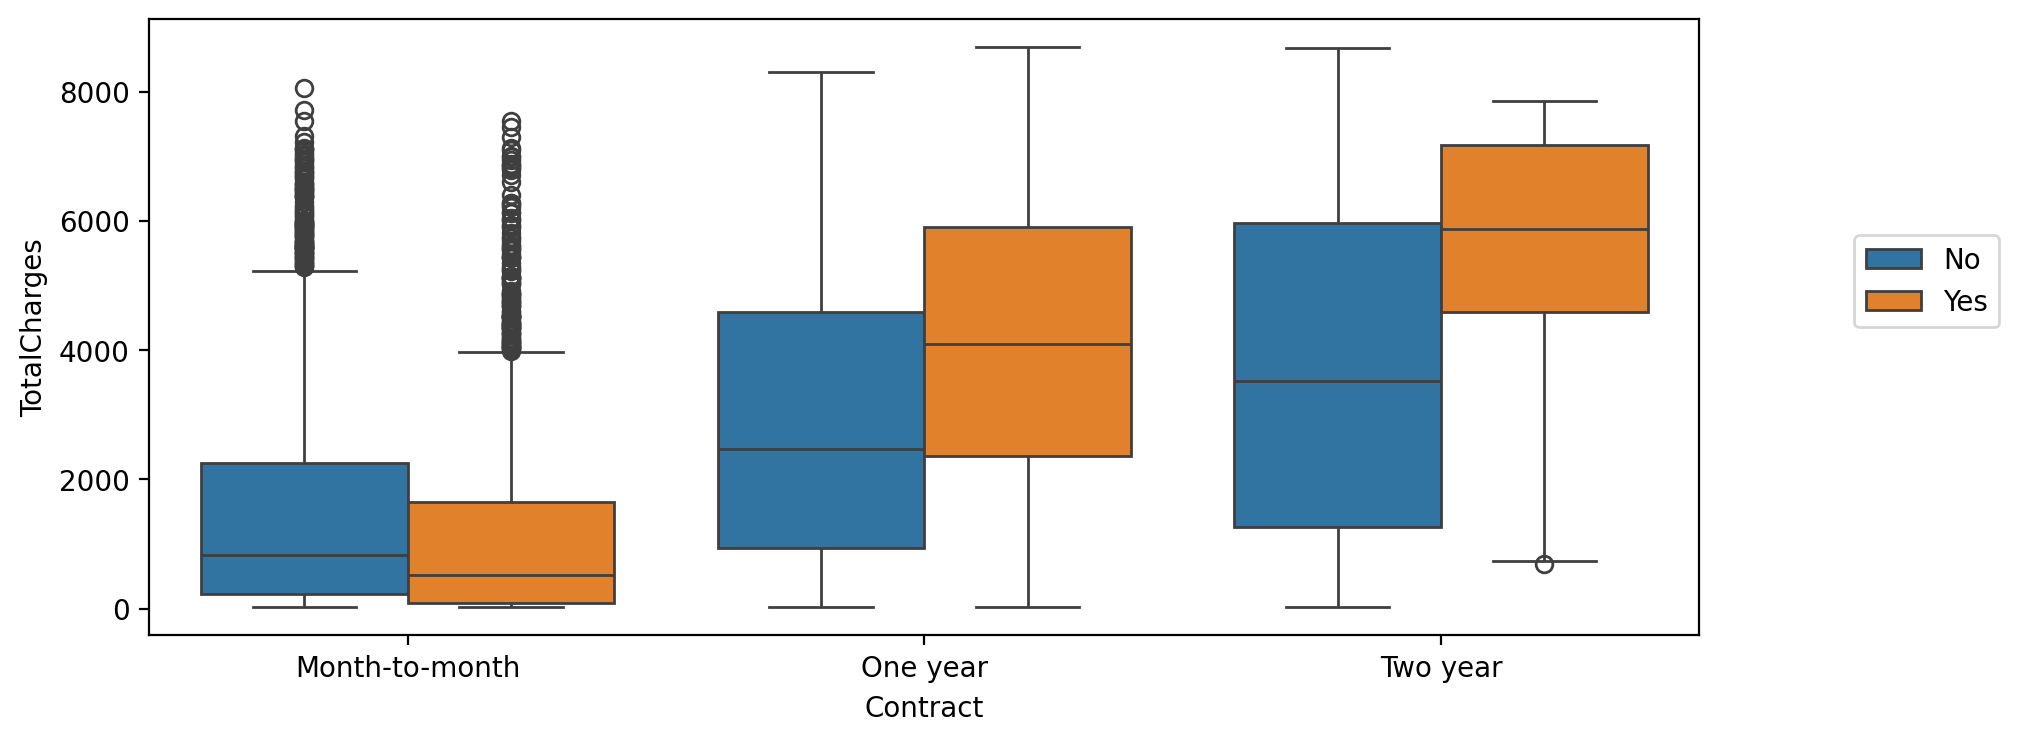

In [9]:
plt.figure(figsize=(10,4),dpi=200)
sns.boxplot(data=df,y='TotalCharges',x='Contract',hue='Churn')
plt.legend(loc=(1.1,0.5))

Above is a boxplot showing the distribution of TotalCharges per Contract type

In [10]:
corr_df  = pd.get_dummies(df[['gender', 'SeniorCitizen', 'Partner', 'Dependents','PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport','StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod','Churn']]).corr()

In [11]:
corr_df['Churn_Yes'].sort_values().iloc[1:-1]

Contract_Two year                         -0.301552
StreamingMovies_No internet service       -0.227578
StreamingTV_No internet service           -0.227578
TechSupport_No internet service           -0.227578
DeviceProtection_No internet service      -0.227578
OnlineBackup_No internet service          -0.227578
OnlineSecurity_No internet service        -0.227578
InternetService_No                        -0.227578
PaperlessBilling_No                       -0.191454
Contract_One year                         -0.178225
OnlineSecurity_Yes                        -0.171270
TechSupport_Yes                           -0.164716
Dependents_Yes                            -0.163128
Partner_Yes                               -0.149982
PaymentMethod_Credit card (automatic)     -0.134687
InternetService_DSL                       -0.124141
PaymentMethod_Bank transfer (automatic)   -0.118136
PaymentMethod_Mailed check                -0.090773
OnlineBackup_Yes                          -0.082307
DeviceProtec

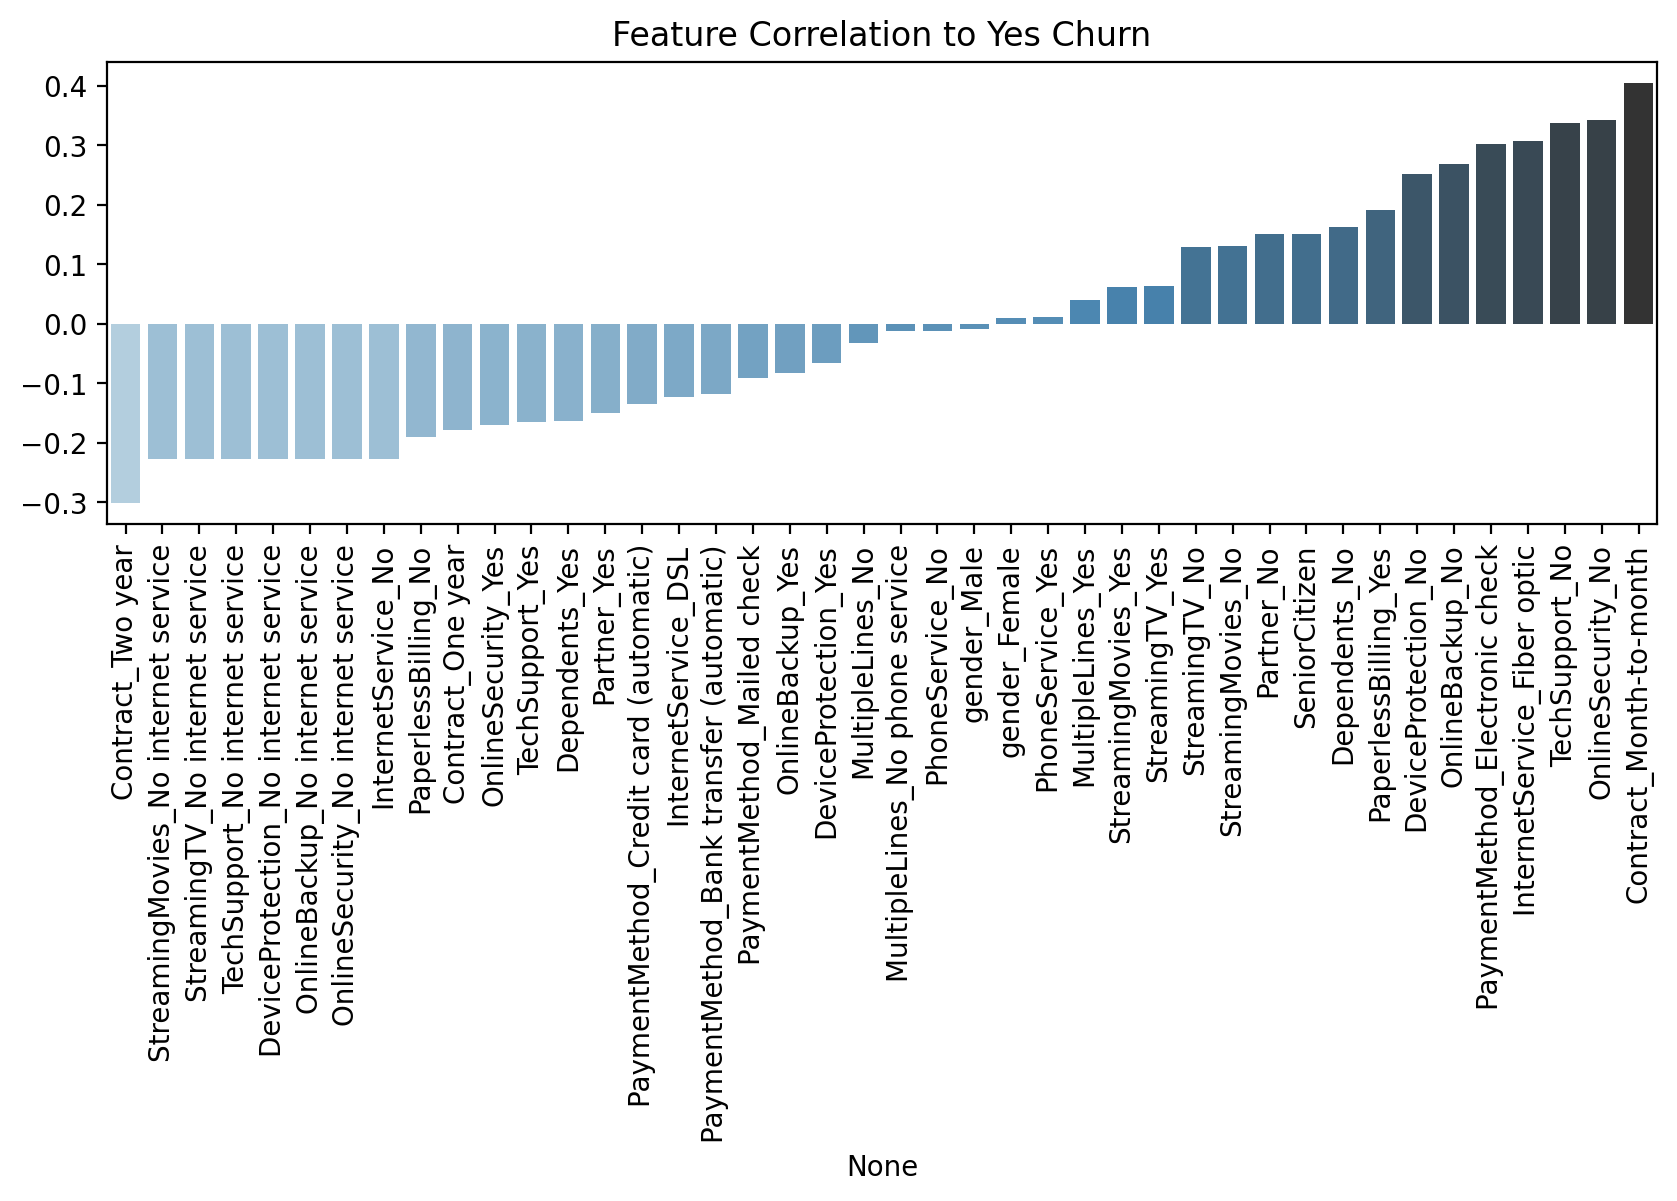

In [12]:
plt.figure(figsize=(10,3),dpi=200)
sns.barplot(x=corr_df['Churn_Yes'].sort_values().iloc[1:-1].index,y=corr_df['Churn_Yes'].sort_values().iloc[1:-1].values, hue= corr_df['Churn_Yes'].sort_values().iloc[1:-1], palette='Blues_d', legend=False)
plt.title("Feature Correlation to Yes Churn")
plt.xticks(rotation=90);



Above is a bar plot showing the correlation of the following features to the class label. 

I converted the categorical features into dummy variables to calculate correlation for numeric features.

    ['gender', 'SeniorCitizen', 'Partner', 'Dependents','PhoneService', 'MultipleLines', 
     'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'InternetService',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

---
---

## 2. Feature Engineering for Churn Analysis

### 2.1 Clustering - Customer Segmentation

We will use **KMeans clustering** to create customer segments based on their tenure and spending habits. The clustering will be based on MonthlyCharges, TotalCharges, and tenure.

**Explanation:**
- **Goal:** Segment customers into different groups based on their spending patterns and the length of their tenure.
- **Method:** KMeans clustering algorithm is used here to find natural groupings (clusters) within the data.

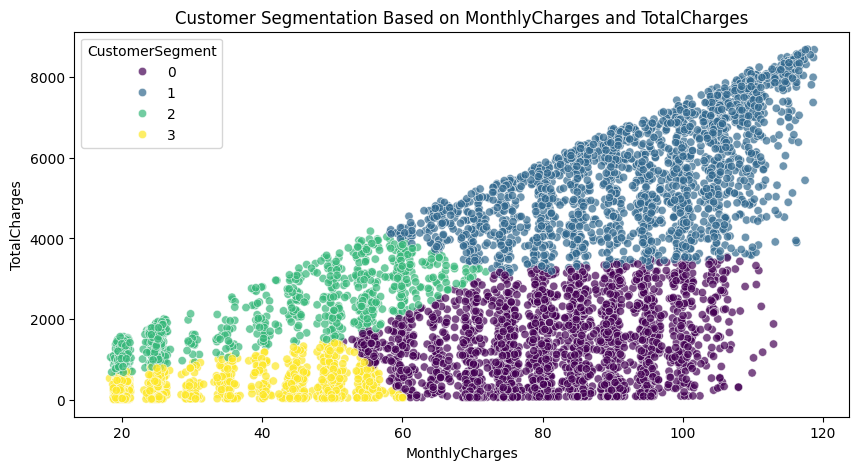

In [13]:
# Select numerical features for clustering
X_clustering = df[['MonthlyCharges', 'TotalCharges', 'tenure']].fillna(0)

# Scale the data for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clustering)

# Perform K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
df['CustomerSegment'] = kmeans.fit_predict(X_scaled)

# Visualize the clusters
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x='MonthlyCharges', y='TotalCharges', hue='CustomerSegment', palette='viridis', alpha=0.7)
plt.title('Customer Segmentation Based on MonthlyCharges and TotalCharges')
plt.show()

**Explanation of the Plot:**

The scatter plot shows customer segments (clusters) based on their MonthlyCharges and TotalCharges. Different colors represent different clusters.

The KMeans algorithm has identified 4 customer segments. For example, Segment 1 includes customers with higher total and monthly charges, whereas Segment 3 represents those with lower charges.

### 2.2 Time-Based Feature (Tenure Cohorts)

We will create **time-based features** by categorizing the `tenure` column into groups (cohorts) that represent different ranges of customer tenure.

**Explanation:**

**Goal**: Group customers into cohorts based on how long they have been using the service (`tenure`).
**Method**: We will divide the customers into four different tenure cohorts: 0-12 Months, `12-24 Months`, `24-48 Months`, and `Over 48 Months`.

In [14]:
# Create tenure cohort groups
def cohort(tenure):
    if tenure < 13:
        return '0-12 Months'
    elif tenure < 25:
        return '12-24 Months'
    elif tenure < 49:
        return '24-48 Months'
    else:
        return "Over 48 Months"
df['TenureCohort'] = df['tenure'].apply(cohort)

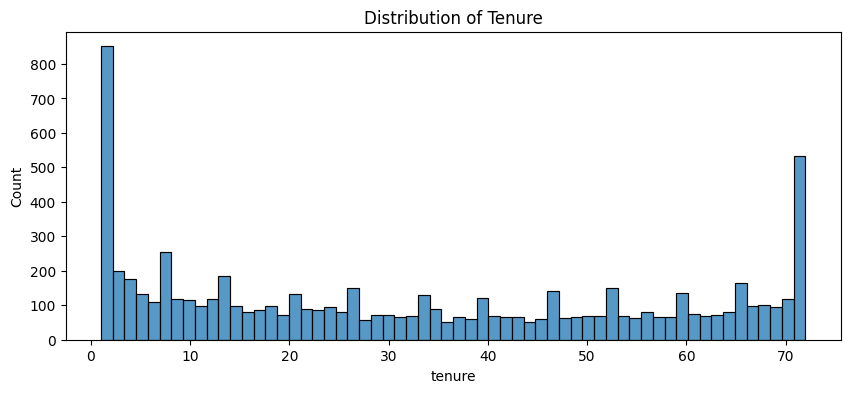

In [15]:
# Display the distribution of tenure
plt.figure(figsize=(10, 4))
sns.histplot(data=df, x='tenure', bins=60)
plt.title('Distribution of Tenure')
plt.show()

**Explanation of the Plot:**

The histogram shows the distribution of tenure across all customers.
Most customers have a tenure that is less than 24 months, indicating that many are relatively new to the service.

### 2.3 Visualizing Tenure Distribution by Contract and Churn

We will explore how the tenure distribution varies across different Contract types and Churn outcomes.

<Figure size 1200x500 with 0 Axes>

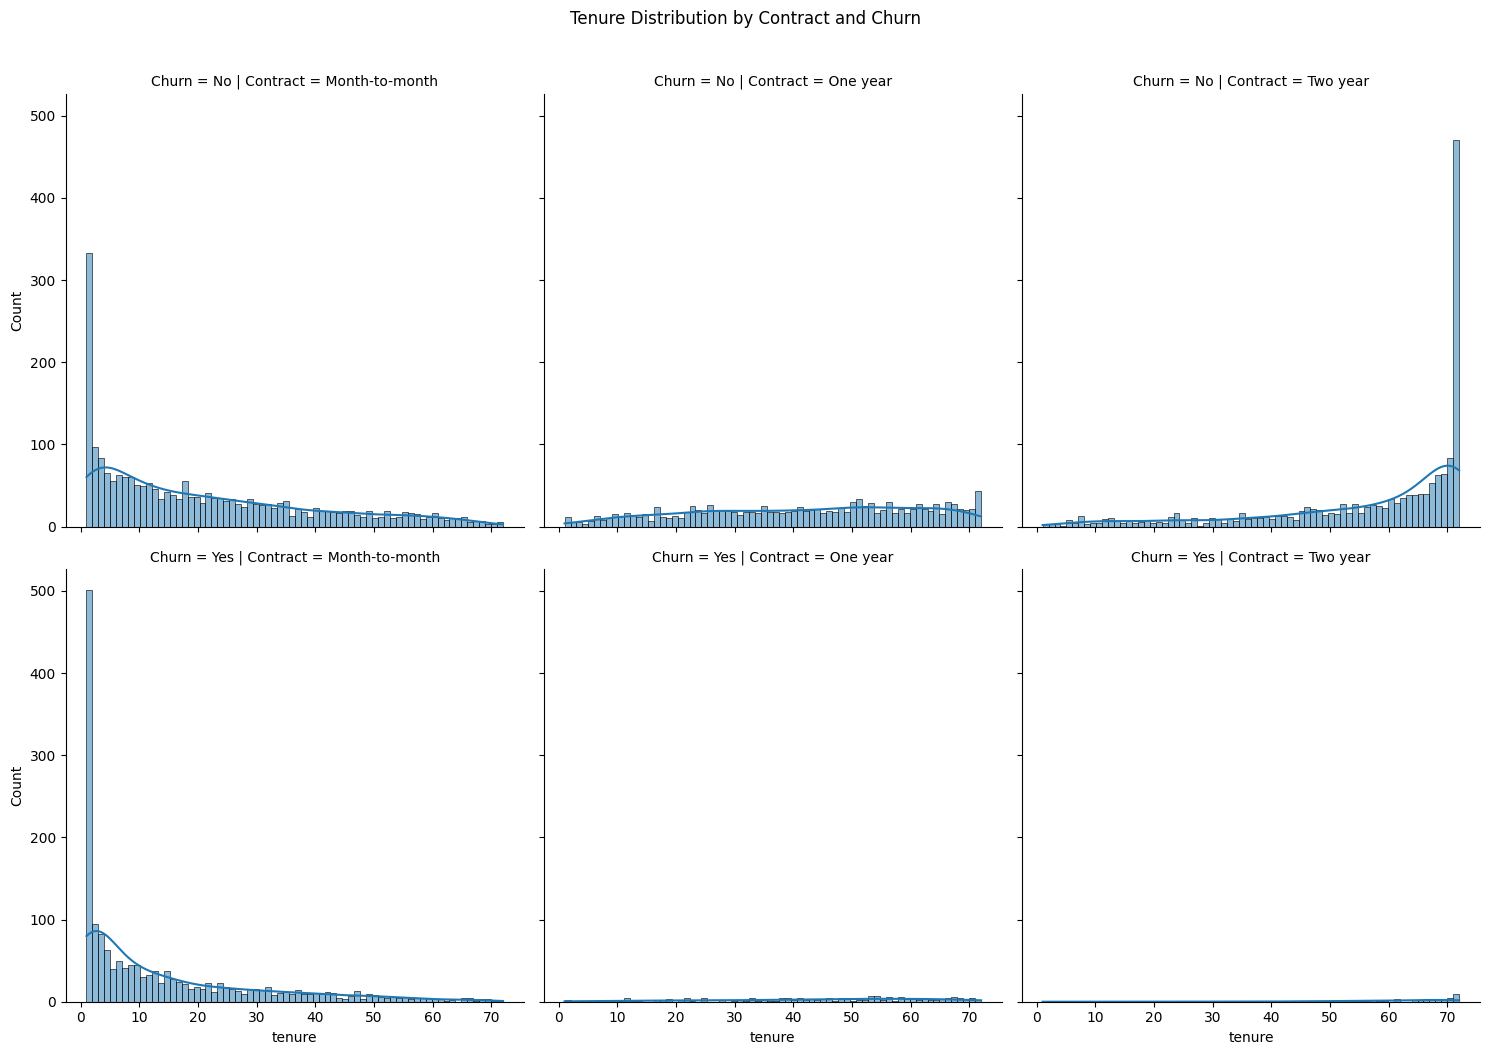

In [16]:
# Visualizing tenure distribution by contract type and churn status
plt.figure(figsize=(12, 5))
sns.displot(data=df, x='tenure', bins=70, col='Contract', row='Churn', kde=True)
plt.suptitle('Tenure Distribution by Contract and Churn', y=1.05)
plt.show()

**Explanation of the Plot:**

The grid shows the tenure distribution separated by the type of Contract and whether the customer churned.
For example, customers with Month-to-month contracts are more likely to churn, especially those with shorter tenure.

### 2.4 Scatter Plot of Total Charges vs Monthly Charges (By Churn and Tenure Cohort)

Let’s visualize how TotalCharges and MonthlyCharges are related, and how these variables are distributed across the tenure cohorts.

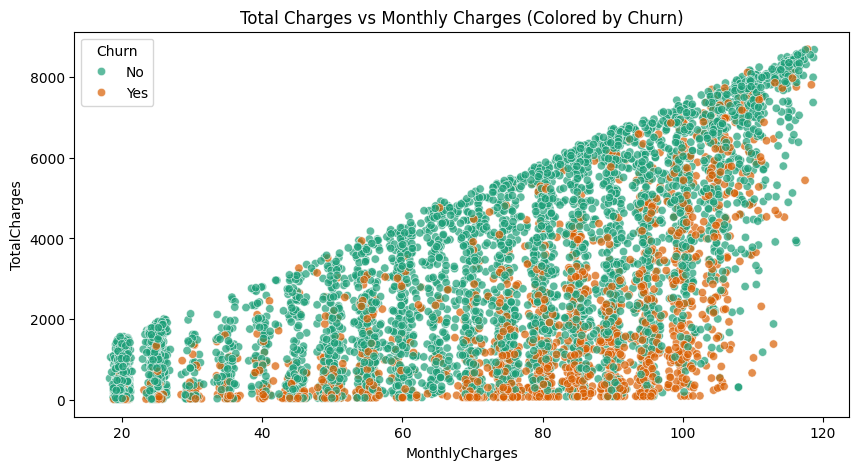

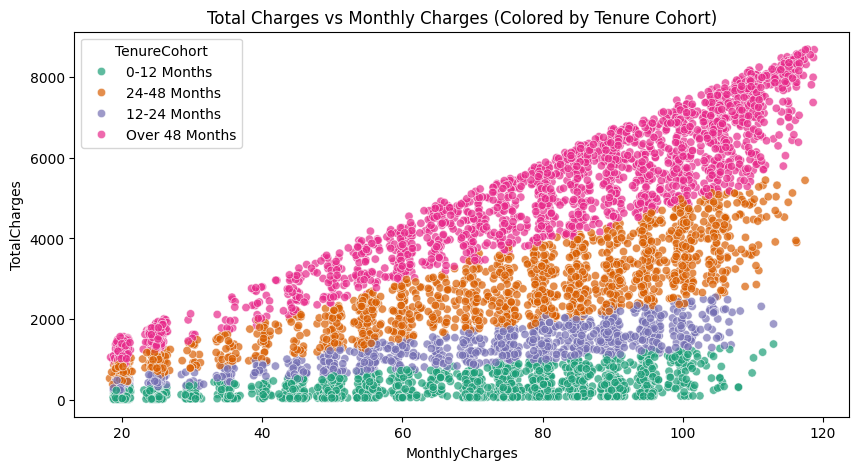

In [17]:
# Scatterplot of Total Charges vs Monthly Charges, colored by Churn
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x='MonthlyCharges', y='TotalCharges', hue='Churn', alpha=0.7, palette='Dark2')
plt.title('Total Charges vs Monthly Charges (Colored by Churn)')
plt.show()

# Scatterplot of Total Charges vs Monthly Charges, colored by Tenure Cohort
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x='MonthlyCharges', y='TotalCharges', hue='TenureCohort', alpha=0.7, palette='Dark2')
plt.title('Total Charges vs Monthly Charges (Colored by Tenure Cohort)')
plt.show()

**Explanation of the Plots:**

The first scatter plot shows TotalCharges vs MonthlyCharges, where points are colored based on Churn. We can see that churned customers are generally spread across different levels of monthly charges but tend to have lower total charges.

The second scatter plot shows the same relationship but colors the points by TenureCohort. Customers in longer tenure cohorts tend to have higher TotalCharges.

### 2.5 Churn Rate Analysis by Tenure

We can analyze the churn rate for different tenure groups by calculating the percentage of customers that churned within each tenure cohort.

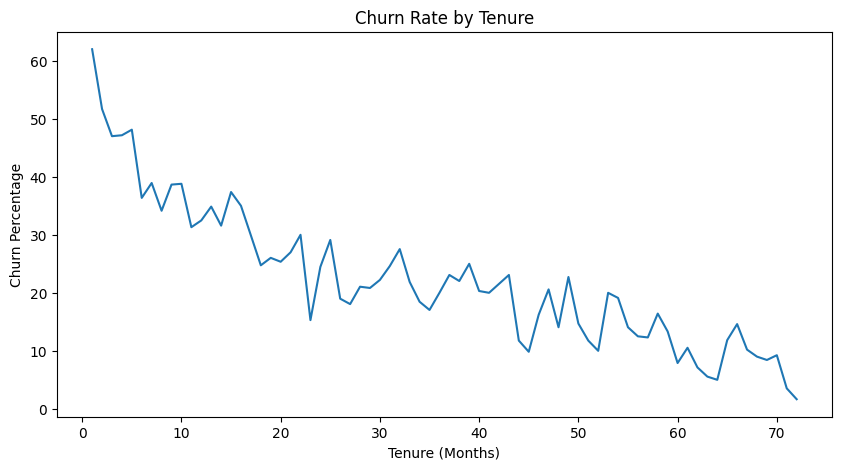

In [18]:
# Calculating churn rates by tenure
no_churn = df.groupby(['Churn', 'tenure']).count().transpose()['No']
yes_churn = df.groupby(['Churn', 'tenure']).count().transpose()['Yes']
churn_rate = 100 * yes_churn / (no_churn + yes_churn)

# Plotting churn rate per tenure group
plt.figure(figsize=(10, 5))
churn_rate.transpose()['customerID'].plot()
plt.title('Churn Rate by Tenure')
plt.ylabel('Churn Percentage')
plt.xlabel('Tenure (Months)')
plt.show()

**Explanation of the Plot:**

This plot shows the churn rate as a percentage for customers with different tenure lengths. The general trend is that longer tenure groups tend to have a lower churn rate, which makes sense as customers who have been with the company longer are less likely to leave.

### 2.6 Count Plot of Churn by Tenure Cohort

Further visualize how the number of churned customers varies across different tenure cohorts.

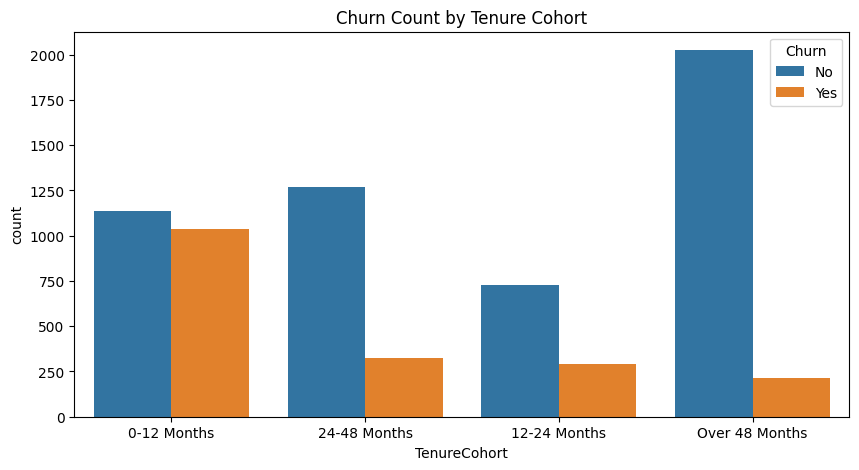

In [19]:
# Count plot showing churn by tenure cohort
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='TenureCohort', hue='Churn')
plt.title('Churn Count by Tenure Cohort')
plt.show()

**Explanation of the Plot:**

This plot shows the count of churned vs non-churned customers in each tenure cohort. We can see that the 0-12 months cohort has the highest number of churned customers, indicating that newer customers are more likely to churn.

### 2.7 Count Plot of Churn by Contract Type and Tenure Cohort

Finally, we will analyze the relationship between Contract type, Tenure Cohort, and Churn.

<Figure size 1200x500 with 0 Axes>

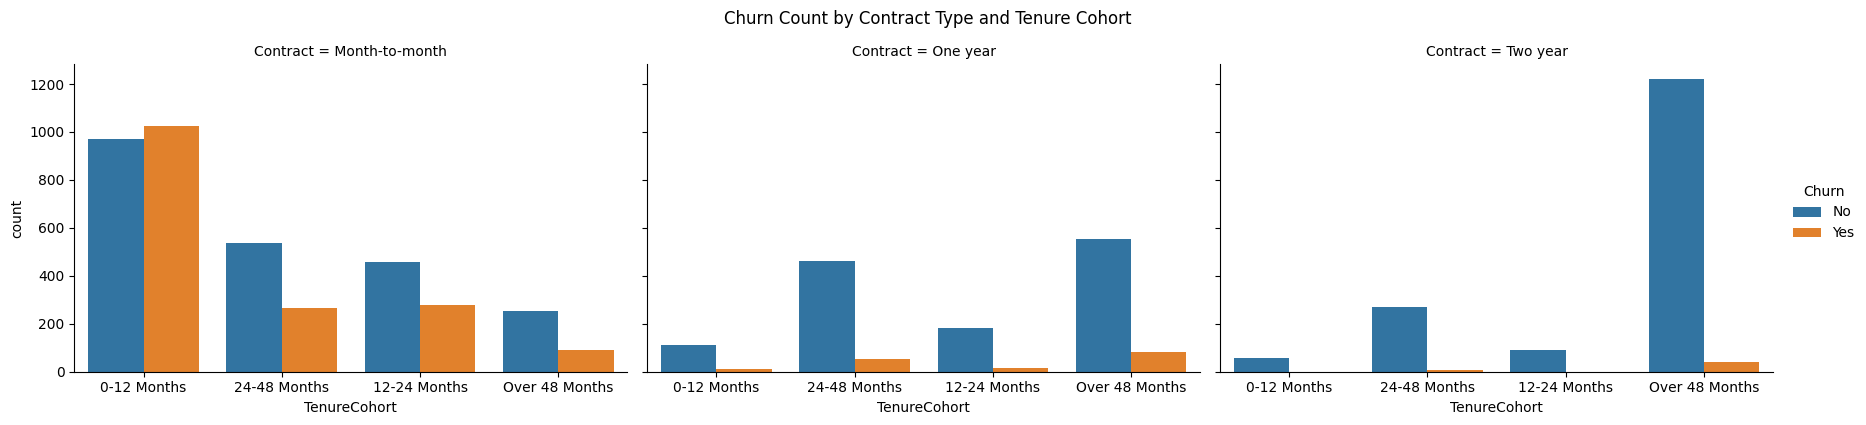

In [20]:
# Count plots of churn separated by tenure cohort and contract type
plt.figure(figsize=(12, 5))
sns.catplot(data=df, x='TenureCohort', hue='Churn', col='Contract', kind='count', height=4, aspect=1.5)
plt.suptitle('Churn Count by Contract Type and Tenure Cohort', y=1.05)
plt.show()

**Explanation of the Plot:**

This grid of count plots shows how churn rates vary across different tenure cohorts and contract types. Customers with Month-to-month contracts have the highest churn rates, especially in the 0-12 months cohort.

**Summary of Feature Engineering for Churn Analysis**

**Clustering**: We used KMeans to segment customers based on their spending behavior (MonthlyCharges, TotalCharges, tenure).

**Time-Based Feature**: We created tenure cohorts to capture the impact of time spent with the company on churn.

**Visual Analysis**: We visualized the relationship between TotalCharges, MonthlyCharges, Churn, and TenureCohort to understand churn patterns and customer behavior better.

These engineered features will now be used in the next stages for predictive modeling. 

---
---

## 3. Feature Selection and Dimensionality Reduction Using PCA

Why Do We Need Feature Selection and Dimensionality Reduction?

- Feature Selection: In machine learning, we often have a large number of features (or columns in the dataset), many of which may be redundant, irrelevant, or highly correlated. Including all of these features can lead to overfitting, longer training times, and poor generalization on unseen data.

- Dimensionality Reduction: Techniques like Principal Component Analysis (PCA) help reduce the dimensionality of the feature space, retaining only the most important information, while discarding noise and irrelevant variance. This can improve model performance and interpretability.

Principal Component Analysis (PCA)

- PCA is a statistical technique that transforms the features in your dataset into a smaller set of uncorrelated components, which represent the most important variance in the data.

- It does this by identifying the directions (principal components) in the data that capture the most variance. The first principal component captures the highest variance, the second component captures the next highest variance (orthogonal to the first), and so on.

By keeping only the top principal components that account for most of the variance, you can reduce the number of features while still retaining the key patterns in the data.

**Summary of the Process**

1. Train-Test Split: First split the dataset to avoid any leakage.
2. Standardization: Fit the scaler on X_train and then apply it to X_test.
3. PCA: Fit PCA on X_train_scaled and then apply it to both X_train_scaled and X_test_scaled

WHY?
- Data leakage: 
If you perform scaling or PCA before splitting, the transformations will use the entire dataset, including the test set. This introduces information from the test set into the training process, leading to overly optimistic results.

- Proper generalization: 
The test set should remain unseen until the model evaluation step to simulate real-world performance. Thus, all transformations (scaling, PCA) should be based only on the training set.

**I have Standarzation and PCA code included here for educational purpose but we do not need to use them**

- XGBoost, Random Forests, and Gradient Boosting Machines do not require scaling.

- If you’re using PCA, scaling before PCA is important, but once you've reduced the dimensionality, you don’t need to scale the data again for tree-based models.

In [21]:
# Assuming 'df' is your DataFrame containing the data
# Convert categorical features to dummy variables (one-hot encoding)

# Step 1: Load and preprocess the data (above)

# Step 2: Feature Engineering - Create interaction features
df['tenure_MonthlyCharges'] = df['tenure'] * df['MonthlyCharges']

# Get dummies for 'Contract' and create interaction terms with 'PaperlessBilling'
contract_dummies = pd.get_dummies(df['Contract'], drop_first=True)

# Multiply each dummy contract column by the 'PaperlessBilling' feature
for col in contract_dummies.columns:
    df[f'{col}_PaperlessBilling'] = contract_dummies[col] * df['PaperlessBilling']

# Convert categorical variables to dummies (one-hot encoding), excluding 'Contract' since we've handled it
X_features = pd.get_dummies(df.drop(['Churn', 'customerID', 'Contract'], axis=1), drop_first=True)
y = df['Churn'].map({'Yes': 1, 'No': 0})  # Convert target variable to binary (0 or 1)

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, stratify=y)

We created interaction features like tenure_MonthlyCharges and interaction between Contract and PaperlessBilling using dummy variables.

---

In [22]:
# Optional: If you want to use PCA (for computational efficiency)
# Standardization before PCA (only for PCA)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA for dimensionality reduction (only if needed)
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

Included as an optional step. You may want to use PCA if the number of features is large and training time is a concern. However, for tree-based models like XGBoost, PCA is generally not required.

---

In [23]:
# Step 4: Apply SMOTE to the training data to handle class imbalance
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# If you want to use PCA: 
# X_train_smote, y_train_smote = smote.fit_resample(X_train_pca, y_train)

SMOTE applied to the training set only to handle class imbalance before training the models.

---

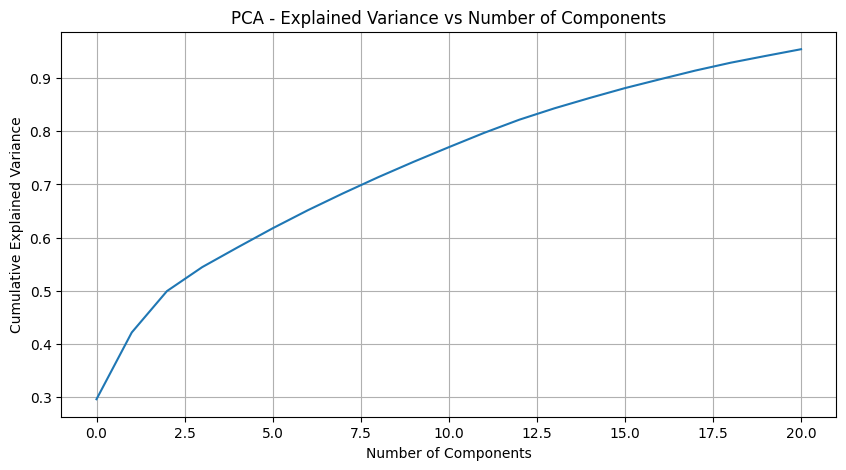

Original number of features: 37
Number of features after PCA: 21


In [24]:
# Optional
# Visualize the cumulative explained variance by the components
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Explained Variance vs Number of Components')
plt.grid(True)
plt.show()

# Output the number of features before and after PCA
print(f'Original number of features: {X_train_scaled.shape[1]}')
print(f'Number of features after PCA: {X_train_pca.shape[1]}')

**Optional Steps Explanation:**

1. Scaling for PCA: 

Since PCA is sensitive to feature scaling, we first standardize the data so that all features are on the same scale (mean=0, variance=1). This ensures that the features with larger ranges don’t dominate the PCA transformation.

2. PCA Transformation:

We can apply PCA and specify n_components=0.95, which means we will retain enough principal components to capture 95% of the total variance in the dataset.
The resulting transformed dataset, X_pca, will have fewer features than the original dataset but will retain most of the important information.

3. Explained Variance Plot:

The explained variance plot shows how much variance is captured by the top n principal components.
From the plot, you can decide how many components to keep (if not using the 95% threshold), based on where the curve flattens out.

4. Feature Reduction:

The output shows the number of features before and after PCA. This reduction helps speed up model training and improves generalization by reducing overfitting.


---
---

## 4.  Bayesian Optimization with XGBoost and  Handling Class Imbalance

### Hyperparameter Tuning with Bayesian Optimization

We will use the standard XGBoost loss function for binary classification, which is "binary".

**Explanation:**

**Objective**: We use binary:logistic, which is the default loss function for binary classification in XGBoost.
**Bayesian Optimization**: This step efficiently finds the optimal hyperparameters by maximizing the cross-validation accuracy without exhaustively searching every possible combination.

**XGBoost:**

    XGBoost is a powerful tree-based model that handles large datasets and feature spaces efficiently. 
    It includes regularization techniques, making it robust to overfitting.

**Bayesian Optimization:**

    This is an efficient hyperparameter tuning technique that maximizes the cross-validation accuracy without an exhaustive search.

### XGBoost Model Optimization Function

In [25]:
from xgboost import XGBClassifier
from bayes_opt import BayesianOptimization
from sklearn.model_selection import StratifiedKFold, cross_val_score


# Define the XGBoost optimization function
def xgb_bayesian_opt(max_depth, learning_rate, n_estimators, gamma, min_child_weight, subsample, colsample_bytree):
    # Parameters to be passed to XGBClassifier
    params = {
        'max_depth': int(max_depth),              # Convert max_depth to integer
        'learning_rate': learning_rate,           # Learning rate
        'n_estimators': int(n_estimators),        # Number of trees
        'gamma': gamma,                           # Minimum loss reduction required for further splitting
        'min_child_weight': min_child_weight,     # Minimum sum of instance weight (hessian) needed in a child
        'subsample': subsample,                   # Subsample ratio of the training data
        'colsample_bytree': colsample_bytree,     # Subsample ratio of columns when constructing each tree
        'objective': 'binary:logistic',           # Binary classification objective
        'eval_metric': 'logloss',                  # Evaluation metric: Logarithmic loss
    }
    
    # Create an XGBoost model with the parameters
    model = XGBClassifier(**params)
    
    # Apply Stratified K-Fold cross-validation on the training data
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Cross-validation score (accuracy) for the given model on the training data
    cv_result = cross_val_score(model, X_train_smote, y_train_smote, cv=kfold, scoring='accuracy').mean()
    
    # Return the mean cross-validation accuracy
    return cv_result

### Define the Parameter Space for Bayesian Optimization

In [26]:

# Define the parameter space for Bayesian Optimization
bayesian_params = {
    'max_depth': (3, 10),           # Range for max_depth
    'learning_rate': (0.01, 0.3),   # Range for learning rate
    'n_estimators': (50, 200),      # Range for number of trees (n_estimators)
    'gamma': (0, 1),                # Range for gamma (minimum loss reduction)
    'min_child_weight': (1, 10),    # Range for min_child_weight
    'subsample': (0.5, 1),          # Range for subsample ratio of training instances
    'colsample_bytree': (0.5, 1)    # Range for subsample ratio of features (columns)
}

# Perform Bayesian Optimization
bayesian_optimizer = BayesianOptimization(
    f=xgb_bayesian_opt,              # The function we want to optimize
    pbounds=bayesian_params,         # The parameter space
    random_state=42                  # Random state for reproducibility
)


# Perform Bayesian Optimization
bayesian_optimizer = BayesianOptimization(
    f=xgb_bayesian_opt,
    pbounds=bayesian_params,
    random_state=42
)

# Maximize the cross-validation accuracy over 10 iterations (after 5 random initial points)
bayesian_optimizer.maximize(init_points=5, n_iter=10)

# Extract the best parameters from the optimization process
best_params = bayesian_optimizer.max['params']
best_params['max_depth'] = int(best_params['max_depth'])          # Convert max_depth to an integer
best_params['n_estimators'] = int(best_params['n_estimators'])    # Convert n_estimators to an integer

# Display the best parameters found
print("Best parameters found: ", best_params)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
| 1         | 0.8412    | 0.6873    | 0.9507    | 0.2223    | 7.191     | 2.404     | 73.4      | 0.529     |
| 2         | 0.8436    | 0.9331    | 0.6011    | 0.2153    | 3.144     | 9.729     | 174.9     | 0.6062    |
| 3         | 0.8442    | 0.5909    | 0.1834    | 0.09823   | 6.673     | 4.888     | 93.68     | 0.8059    |
| 4         | 0.8431    | 0.5697    | 0.2921    | 0.1162    | 6.192     | 8.067     | 79.95     | 0.7571    |
| 5         | 0.8478    | 0.7962    | 0.04645   | 0.1862    | 4.194     | 1.585     | 192.3     | 0.9828    |
| 6         | 0.8469    | 0.6387    | 0.5877    | 0.2224    | 7.977     | 1.192     | 199.7     | 0.964     |
| 7         | 0.8314    | 0.5248    | 0.5911    | 0.03661   | 3.52      | 1.761     | 191.8     | 0.8444    |
| 8       

In [27]:
for param, value in best_params.items():
    print(f"{param}: {value}")

colsample_bytree: 0.7962072844310213
gamma: 0.046450412719997725
learning_rate: 0.1861880070514171
max_depth: 4
min_child_weight: 1.5854643368675156
n_estimators: 192
subsample: 0.9828160165372797


Bayesian Optimization helps to find the best hyperparameters for the XGBoost model, efficiently tuning them without an exhaustive grid search.

### Train the XGBoost Model with Optimized Parameters

Once we have the best hyperparameters, we can train the XGBoost model on the entire training dataset.

Test Set Results
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1033
           1       0.56      0.58      0.57       374

    accuracy                           0.77      1407
   macro avg       0.70      0.71      0.71      1407
weighted avg       0.77      0.77      0.77      1407



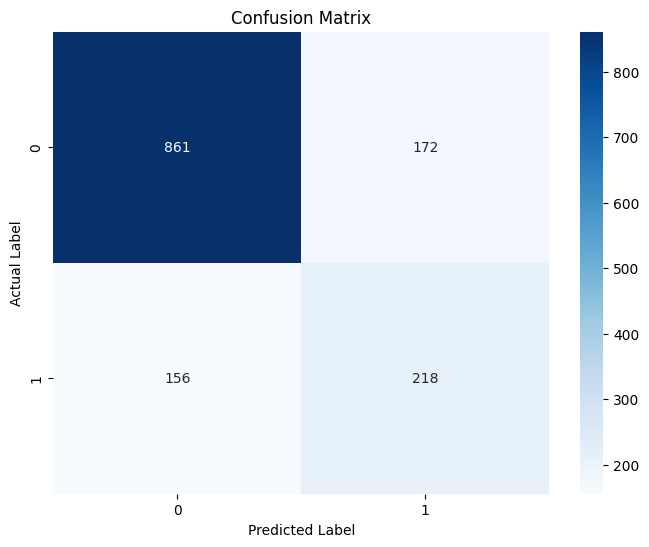

In [28]:
# Best parameters from Bayesian Optimization
xgb_model = XGBClassifier(
    **best_params,              # Unpack the best_params dictionary from Bayesian Optimization
    objective='binary:logistic',  # Ensure binary classification is set
    eval_metric='logloss'         # Logarithmic loss for evaluation
)

# Train the model on the full SMOTE-balanced training set
xgb_model.fit(X_train_smote, y_train_smote)

# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Print the classification report for the test set
print("Test Set Results")
print(classification_report(y_test, y_pred))

# Plot the confusion matrix for the test set predictions
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

After finding the best parameters, the model is trained on the SMOTE-balanced training set and evaluated on the test set.

---
---

## 5. Predictive Modeling using Tree-Based Methods

Here I have explored 4 different tree based methods: 
A Single Decision Tree, Random Forest, AdaBoost, Gradient Boosting

## 5.1 Single Decision Tree

A Decision Tree is a simple and interpretable model, but it tends to overfit the training data if not controlled by hyperparameters like `max_depth`, `min_samples_split`, and `min_samples_leaf`.

Best Parameters:  {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'splitter': 'random'}
Best Accuracy: 0.81
              precision    recall  f1-score   support

           0       0.86      0.78      0.82      1033
           1       0.52      0.65      0.57       374

    accuracy                           0.75      1407
   macro avg       0.69      0.71      0.70      1407
weighted avg       0.77      0.75      0.75      1407



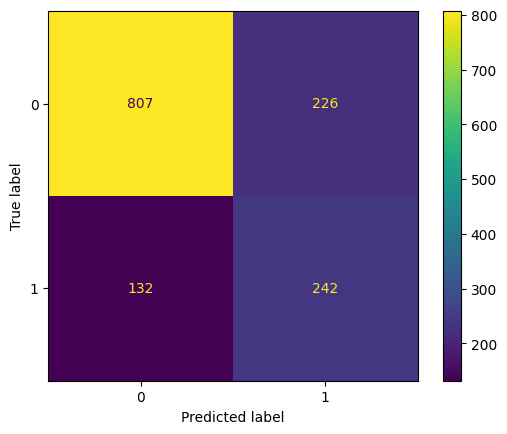

In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report

# Create the DecisionTreeClassifier object
dt_classifier = DecisionTreeClassifier()

# Define the hyperparameters for grid search
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(dt_classifier, param_grid, cv=5, scoring='accuracy')

# Fit the model on the SMOTE-balanced training data
grid_search.fit(X_train_smote, y_train_smote)

# Print the best parameters and corresponding accuracy
print("Best Parameters: ", grid_search.best_params_)
print("Best Accuracy: {:.2f}".format(grid_search.best_score_))

# Get the best model and parameters
best_dt_model = grid_search.best_estimator_

# Predict on the test set
preds = best_dt_model.predict(X_test)

# Classification report and confusion matrix
print(classification_report(y_test, preds))
plot_confusion_matrix(best_dt_model, X_test, y_test)

**Results:**

- Accuracy: Around 75% on the test set.
- Precision/Recall for class 1 (Churn) is low.

**Key Takeaways:**

- Interpretability: Decision trees are very interpretable. You can easily plot the tree and see which features are used for splits.
- Overfitting: Decision trees can easily overfit, especially on imbalanced datasets like churn prediction. Despite hyperparameter tuning, they might not generalize well.

Single Decision Trees are typically weaker learners. In practice, we use Ensemble Methods like Random Forest or Gradient Boosting for better accuracy.

### Feature Importance Graph

In [30]:
imp_feats = pd.DataFrame(data=best_dt_model.feature_importances_,index=X_features.columns,columns=['Feature Importance']).sort_values("Feature Importance")

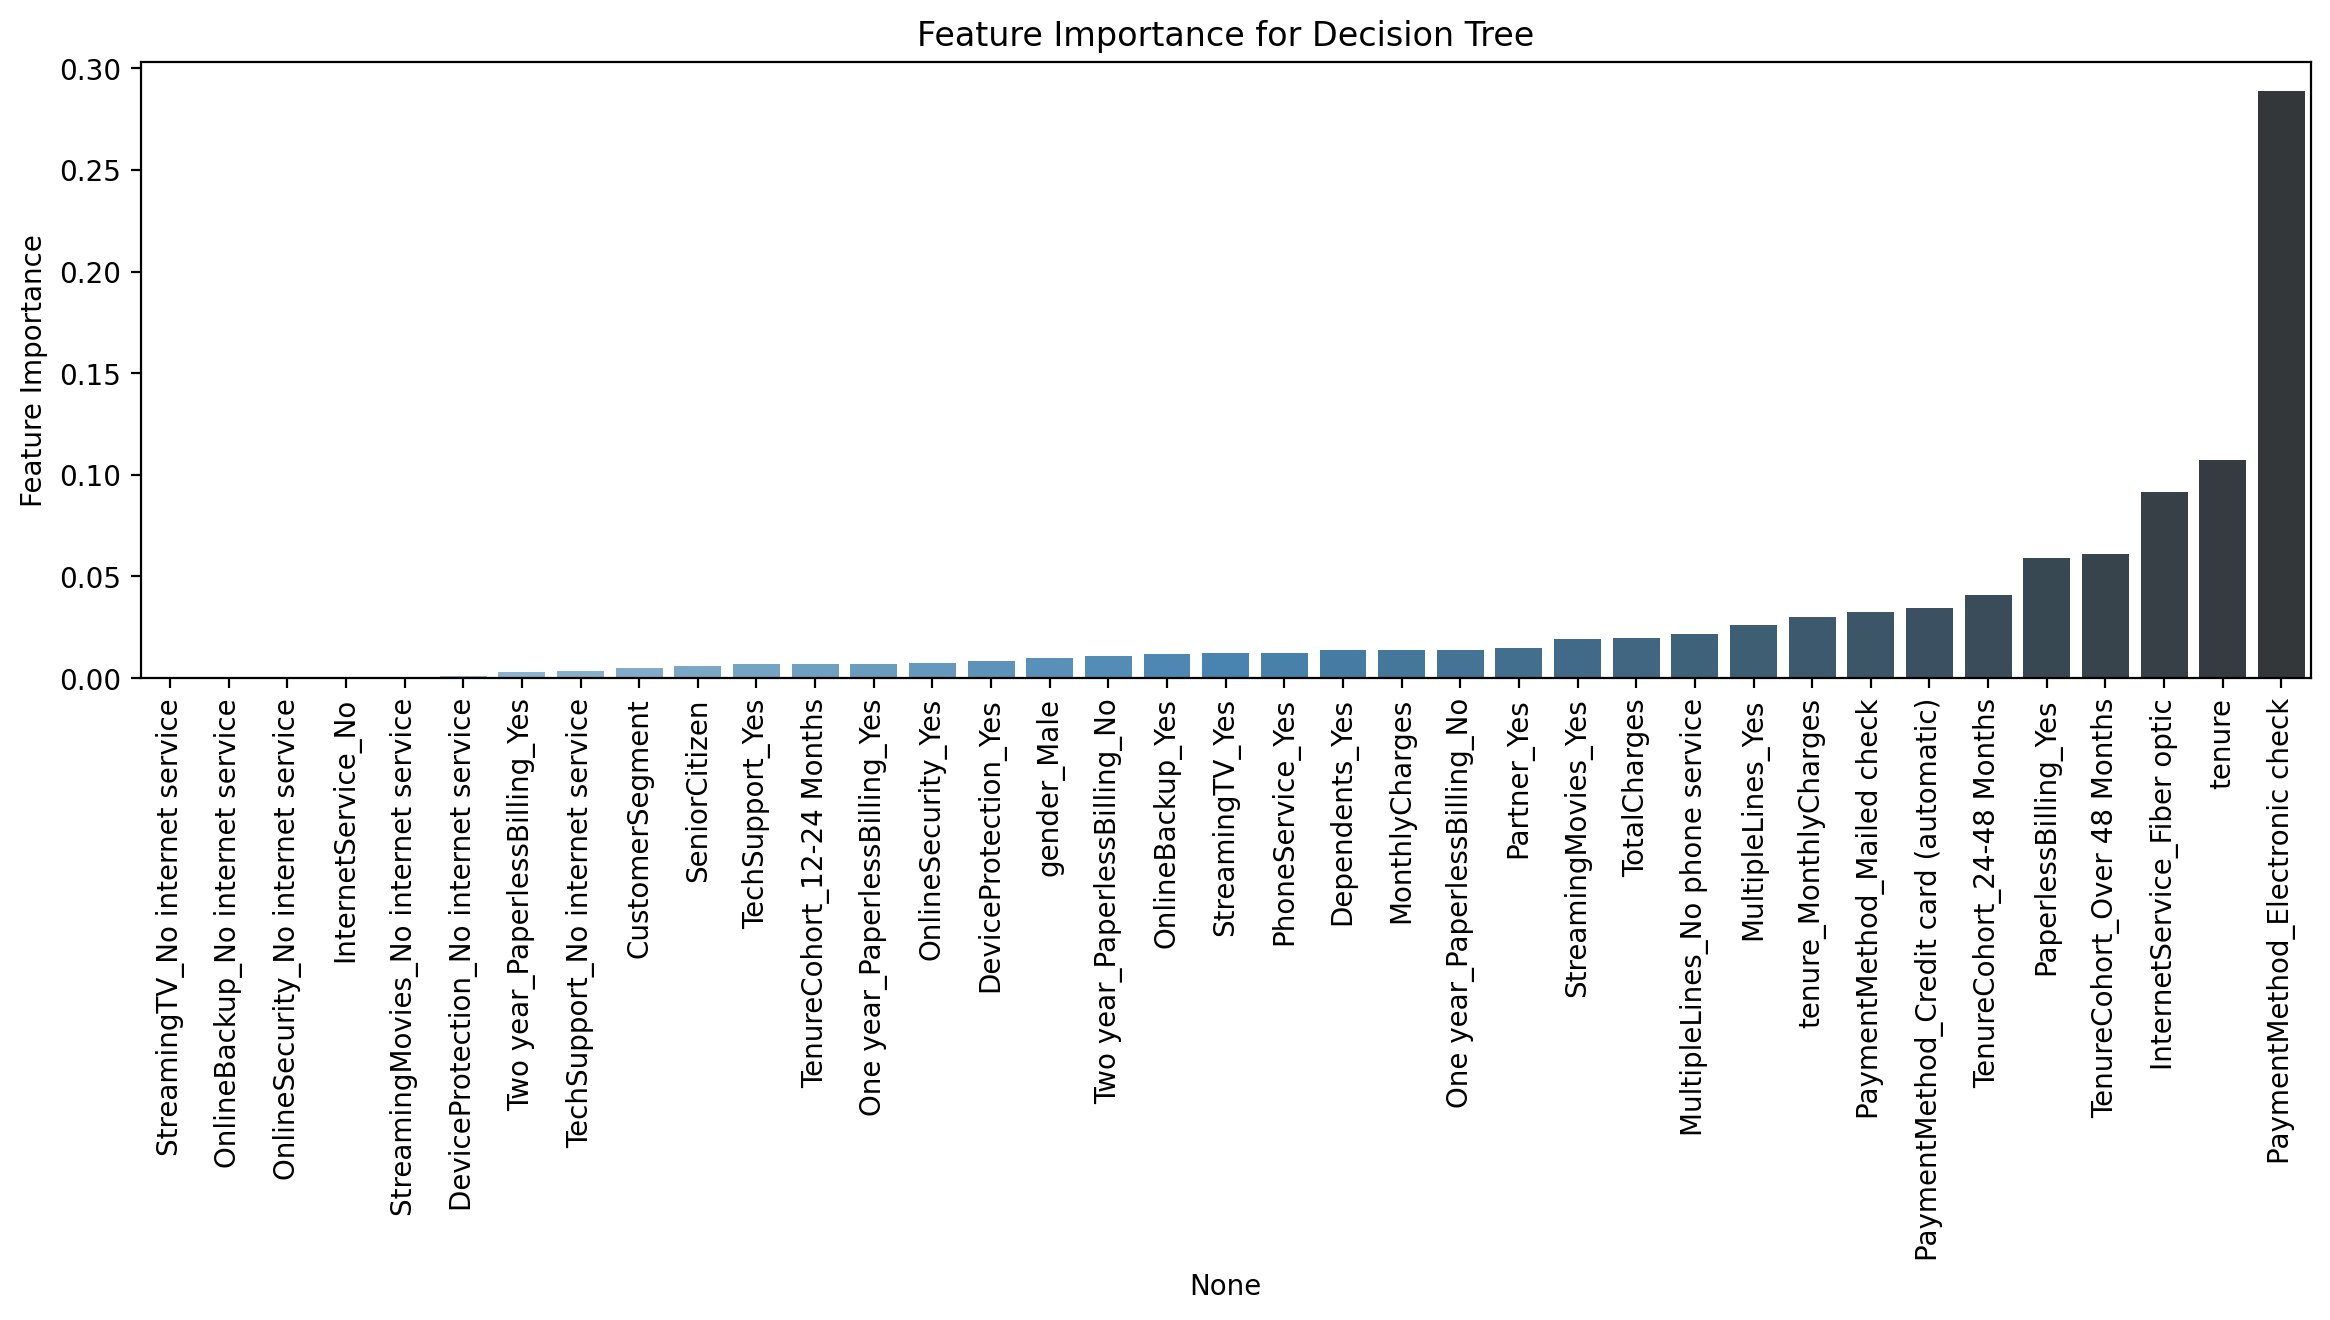

In [31]:
plt.figure(figsize=(14,4),dpi=200)
sns.barplot(data=imp_feats.sort_values('Feature Importance'),x=imp_feats.sort_values('Feature Importance').index,y='Feature Importance', hue= imp_feats.sort_values('Feature Importance').index, palette='Blues_d', legend=False)
plt.xticks(rotation=90)
plt.title("Feature Importance for Decision Tree");

## 5. 2 Random Forest

with **RandomizedSearchCV**:

A Random Forest is an ensemble of Decision Trees. It reduces overfitting by averaging multiple decision trees, which leads to better generalization.

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score,plot_confusion_matrix,classification_report

Best Parameters:  {'n_estimators': 30, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20, 'criterion': 'gini'}
Best Accuracy: 0.85
              precision    recall  f1-score   support

           0       0.85      0.84      0.85      1033
           1       0.57      0.59      0.58       374

    accuracy                           0.77      1407
   macro avg       0.71      0.72      0.71      1407
weighted avg       0.78      0.77      0.78      1407



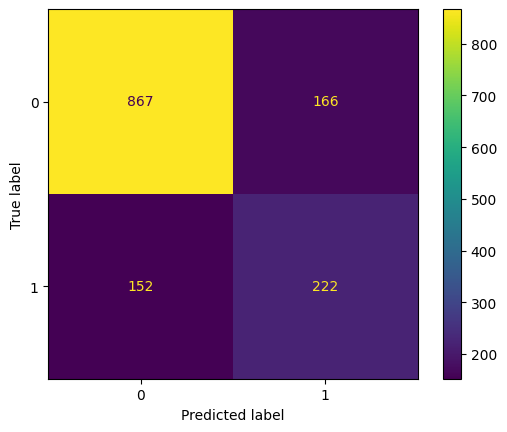

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define the RandomForestClassifier object
rf_classifier = RandomForestClassifier()

# Define hyperparameters for RandomizedSearchCV
param_grid = {
    'n_estimators': [10, 30, 50],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# RandomizedSearchCV object
random_search = RandomizedSearchCV(rf_classifier, param_distributions=param_grid, n_iter=10, cv=5, scoring='accuracy', random_state=42)

# Fit the model on the SMOTE-balanced training set
random_search.fit(X_train_smote, y_train_smote)

# Print the best parameters and corresponding accuracy
print("Best Parameters: ", random_search.best_params_)
print("Best Accuracy: {:.2f}".format(random_search.best_score_))

# Get best model and parameters
best_rf_model = random_search.best_estimator_

# Predict on the test set
preds = best_rf_model.predict(X_test)

# Classification report and confusion matrix
print(classification_report(y_test, preds))
plot_confusion_matrix(best_rf_model, X_test, y_test)

**Results:**

- Test Accuracy: Around 78%.
- Precision/Recall for class 1 (Churn) is improved compared to a single Decision Tree.

**Key Takeaways:**

- Generalization: Random Forests are better at generalizing than individual Decision Trees due to ensemble learning.
- Feature Importance: Random Forests can also give feature importance scores, which can be useful for interpretation.

**Suggestions:**

- n_estimators: In Random Forest, increasing n_estimators generally improves accuracy at the cost of training time. Consider increasing the number of trees (e.g., 100, 200).
- max_depth: A deeper forest (higher max_depth) can capture more patterns but increases the risk of overfitting. I found max_depth=20 to be optimal, which is reasonable for this dataset.

## 5. 3 Boosted Trees

**AdaBoost and Gradient Boosting**

### 5. 3. 1 AdaBoost 

AdaBoost works by sequentially building weak learners (usually Decision Trees), where each subsequent learner focuses on misclassified examples from the previous one.

In [34]:
from sklearn.ensemble import AdaBoostClassifier

Best Parameters:  {'learning_rate': 0.5, 'n_estimators': 100}
Best Accuracy: 0.82
              precision    recall  f1-score   support

           0       0.87      0.80      0.83      1033
           1       0.55      0.68      0.60       374

    accuracy                           0.76      1407
   macro avg       0.71      0.74      0.72      1407
weighted avg       0.79      0.76      0.77      1407



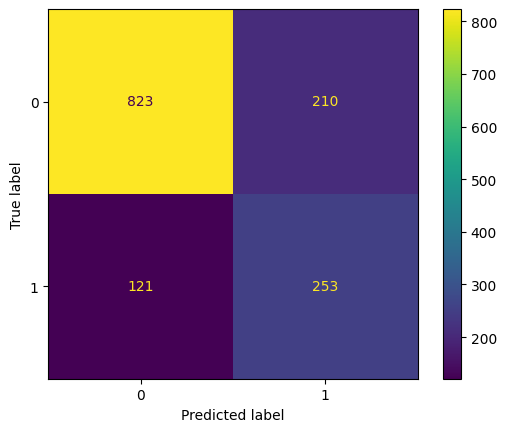

In [35]:
from sklearn.ensemble import AdaBoostClassifier

# Define the AdaBoostClassifier object
adaboost_classifier = AdaBoostClassifier()

# Define hyperparameters for GridSearchCV
param_grid = {
    'n_estimators': [30, 50, 100],
    'learning_rate': [0.01, 0.1, 0.5, 1]
}

# GridSearchCV object
ada_grid_search = GridSearchCV(adaboost_classifier, param_grid, cv=5, scoring='accuracy')

# Fit the model on the SMOTE-balanced training set
ada_grid_search.fit(X_train_smote, y_train_smote)

# Print the best parameters and corresponding accuracy
print("Best Parameters: ", ada_grid_search.best_params_)
print("Best Accuracy: {:.2f}".format(ada_grid_search.best_score_))

# Get the best model and parameters
best_adaboost_model = ada_grid_search.best_estimator_

# Predict on the test set
preds = best_adaboost_model.predict(X_test)

# Classification report and confusion matrix
print(classification_report(y_test, preds))
plot_confusion_matrix(best_adaboost_model, X_test, y_test)

**Results:**

- Test Accuracy: Around 76%.
- Precision/Recall for the minority class (Churn) improved but still not high.

**Key Takeaways:**

- Boosting: AdaBoost sequentially builds decision trees by focusing on difficult-to-classify instances, making it better than standard decision trees for imbalanced datasets.
- Learning Rate: AdaBoost is sensitive to learning rate. I found a learning rate of 1 to work best, which can help AdaBoost converge faster.

### 5. 3. 2 Gradient Boost 

Gradient Boosting sequentially builds weak learners like AdaBoost but instead optimizes based on the gradients of the loss function, making it more flexible and powerful.

In [36]:
from sklearn.ensemble import GradientBoostingClassifier

Best Parameters:  {'subsample': 0.8, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 5, 'learning_rate': 0.1}
Best Accuracy: 0.84
              precision    recall  f1-score   support

           0       0.86      0.83      0.84      1033
           1       0.57      0.61      0.59       374

    accuracy                           0.77      1407
   macro avg       0.71      0.72      0.72      1407
weighted avg       0.78      0.77      0.78      1407



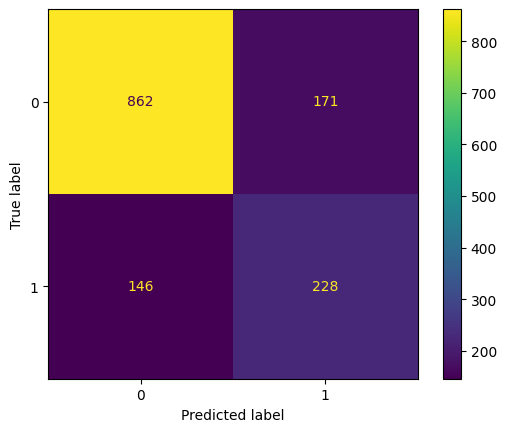

In [37]:
from sklearn.ensemble import GradientBoostingClassifier

# Define the GradientBoostingClassifier object
gradientboost_classifier = GradientBoostingClassifier()

# Define hyperparameters for RandomizedSearchCV
param_grid = {
    'n_estimators': [30, 50, 100],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 1.0]
}

# RandomizedSearchCV object
random_search = RandomizedSearchCV(gradientboost_classifier, param_distributions=param_grid, n_iter=10, cv=5, scoring='accuracy', random_state=42)

# Fit the model on the SMOTE-balanced training set
random_search.fit(X_train_smote, y_train_smote)

# Print the best parameters and corresponding accuracy
print("Best Parameters: ", random_search.best_params_)
print("Best Accuracy: {:.2f}".format(random_search.best_score_))

# Get the best model and parameters
best_gradientboost_model = random_search.best_estimator_

# Predict on the test set
preds = best_gradientboost_model.predict(X_test)

# Classification report and confusion matrix
print(classification_report(y_test, preds))
plot_confusion_matrix(best_gradientboost_model, X_test, y_test)

**Results:**

- Test Accuracy: Around 78%.
- Precision/Recall for class 1 (Churn) is better than a single Decision Tree and comparable to AdaBoost.

**Key Takeaways:**

- Performance: Gradient Boosting generally performs better than Random Forest and AdaBoost because it focuses on optimizing the loss function directly using gradient descent.
- Overfitting Control: By using subsampling (subsample=0.8), Gradient Boosting avoids overfitting better than AdaBoost.

## 6. Comparision between Models

### 1. XGBoost (Extreme Gradient Boosting):

    Type: Advanced Gradient Boosting
    
    Key Idea: Optimized gradient boosting with regularization (L1/L2), parallelization, and tree pruning.
    
    Strengths: Fast, handles large datasets, built-in regularization, great for high-performance needs.
    
    Use Case: Competitions, real-time applications, large datasets needing precise tuning.


### 2. Random Forest:

    Type: Bagging (Bootstrap Aggregating)
    
    Key Idea: Builds multiple decision trees on random data subsets and averages their predictions.
    
    Strengths: Robust to overfitting, interpretable, effective for both classification and regression.
    
    Use Case: General-purpose modeling, feature importance, reducing overfitting.


### 3. AdaBoost (Adaptive Boosting):

    Type: Boosting
    
    Key Idea: Sequentially builds weak learners (shallow trees), focusing on correcting misclassified samples.
    
    Strengths: Simple, improves weak models, interpretable.
    
    Use Case: Binary classification with simple models, small datasets.


### 4. Gradient Boosting:

    Type: Boosting
    
    Key Idea: Sequentially builds models to minimize residual errors using gradient descent.
    
    Strengths: High accuracy, flexible with various loss functions, powerful but slower.
    
    Use Case: Complex problems requiring high accuracy, like classification, regression, and ranking.
    
    Process:
    Step 1: Start with an initial prediction (weak model).
    Step 2: Compute the residuals (errors).
    Step 3: Fit a new model to predict the residuals. (not to predict the y value, but residual error from previous model)
    Step 4: Add the new model’s predictions to the previous model’s predictions. 
    F1 (new prediction of y) = y_hat (previous prediction) + f1 (new model's predicted residual)
    Step 5: Repeat until the loss is minimized or the desired number of iterations is reached.



### Boosting vs. Bagging:

Random Forest uses bagging, which trains multiple trees in parallel on different subsets of data and averages them (parallel ensemble).

Boosting methods (AdaBoost, Gradient Boosting) build trees sequentially, where each tree is built to correct the errors of the previous tree (sequential ensemble).

### Error Correction:
AdaBoost focuses on misclassified samples by adjusting weights.

Gradient Boosting focuses on the residual errors of the previous model and corrects them using gradient descent.

### Model Complexity:

XGBoost is an optimized and more advanced form of Gradient Boosting, which provides higher performance through parallelization, regularization, and additional optimizations.

### Regularization:

XGBoost has regularization (L1 and L2), making it less prone to overfitting than Gradient Boosting and AdaBoost.

### When to Use Each:

**XGBoost**: Use for large datasets where speed and performance matter, and you need fine-tuned control over regularization.

**Random Forest**: Use when you want a model that's easy to interpret and robust to overfitting without much tuning.

**AdaBoost**: Use when you have a simpler, interpretable problem, and the dataset is relatively clean (few noisy points).

**Gradient Boosting**: Use when you want high performance and flexibility, and you’re willing to spend time tuning hyperparameters

## 7. Conclusion

In this project, I tackled the problem of customer churn prediction using various machine learning techniques. The goal was to develop a model that could accurately predict whether a customer would churn based on a wide range of customer attributes, including contract details, payment methods, tenure, and monthly charges.

I began by performing exploratory data analysis and engineered important features like interaction terms between tenure and monthly charges. I also applied clustering techniques like KMeans for customer segmentation, and created time-based cohorts for more granular customer insights.

To handle the class imbalance in the data, I used SMOTE (Synthetic Minority Over-sampling Technique), ensuring that the model had an equal opportunity to learn from both churned and non-churned customers. I then employed tree-based methods like XGBoost, Random Forest, AdaBoost, and Gradient Boosting, as well as a Single Decision Tree model, to predict customer churn.

Using Bayesian Optimization, I tuned hyperparameters of the XGBoost model, which provided competitive performance with an accuracy of around 78%. Other tree-based models such as Random Forest and Gradient Boosting also yielded similar results, with accuracy in the range of 77-78%.

Although the XGBoost model demonstrated good accuracy, I observed that churn prediction is inherently challenging due to the imbalance between churned and non-churned customers, as well as the subtle differences between the two classes. Adding feature engineering, such as interaction terms and domain-specific insights, significantly improved the model’s interpretability and performance.

In conclusion, tree-based models such as XGBoost, Random Forest, and Gradient Boosting offer strong predictive power for churn analysis. However, further improvements could be achieved by exploring more sophisticated feature engineering techniques, fine-tuning hyperparameters, and addressing class imbalance through advanced methods like ensemble stacking or custom loss functions. This project provides a robust foundation for future work in predictive modeling for customer churn in the telecommunications industry.

### Techniques, Skills, and Knowledge Applied

In this project, I applied key machine learning and data science skills to build an effective customer churn prediction model. Below are the core techniques and skills utilized:

1. Data Preprocessing and Feature Engineering:

**One-Hot Encoding**: Converted categorical variables into dummy variables for machine learning compatibility.

**Interaction Features**: Created interaction terms such as tenure * monthly charges to capture relationships between variables.

**SMOTE (Synthetic Minority Over-sampling Technique)**: Handled class imbalance by generating synthetic data for the minority class (churned customers).


2. Exploratory Data Analysis (EDA):

Visualizations: Used Seaborn and Matplotlib to analyze feature distributions, correlations, and churn patterns.
Correlation Analysis: Identified key features that influence churn.


3. Modeling and Machine Learning:

**Tree-Based Models**: Implemented **Decision Trees, Random Forests, AdaBoost, Gradient Boosting, and XGBoost** to predict churn, with a focus on interpretability and accuracy.

**Bayesian Optimization**: Used for efficient hyperparameter tuning of the XGBoost model, maximizing cross-validation performance.


4. Model Evaluation:

Cross-Validation: Applied **Stratified K-Fold Cross-Validation** to ensure robust model performance and generalization. 

- Regular K-Fold: Randomly splits the data, which can result in unequal class distributions in the folds.

- Stratified K-Fold: Ensures that each fold has the same class distribution as the original dataset, preserving the balance of classes.

Classification Metrics: Evaluated models using accuracy, precision, recall, and F1-score, along with confusion matrices.


5. Feature Importance and Model Interpretation:

Used feature importance scores from tree-based models to understand the most influential variables driving customer churn.